In [1]:
import numpy as np
import unet_uae_128_visu_full as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import h5py

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

# Load data

In [4]:
data_dir = '/data/cees/gegewen/well_control_data/'
hf_r = h5py.File(data_dir + 'train_well_control_128x128_400.hdf5', 'r')
train_x = np.array(hf_r.get('k'))
train_y = np.array(hf_r.get('S'))
hf_r.close()

In [5]:
hf_w = h5py.File(data_dir + 'test_well_control_128x128_80.hdf5', 'r')
test_x = np.array(hf_w.get('k'))
test_y = np.array(hf_w.get('S'))
hf_w.close()

In [6]:
# train_x = train_x.reshape(40000, 128, 128, 2)
# train_y = train_y.reshape(40000, 128, 128, 1)
# test_x = test_x.reshape(8000, 128, 128, 2)
# test_y = test_y.reshape(8000, 128, 128, 1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (400, 128, 128, 2)
train_y shape is  (400, 128, 128, 1)
test_x shape is  (80, 128, 128, 2)
test_y shape is  (80, 128, 128, 1)


In [7]:
train_x = train_x[:200, ...]
train_y = train_y[:200, ...]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)

train_x shape is  (200, 128, 128, 2)
train_y shape is  (200, 128, 128, 1)


In [9]:
# test_x[:, :, 1, 1] = 0
# train_x[:, :, 1, 1] = 0

In [11]:
input_shape=(128,128,2)

### Plot training dataset

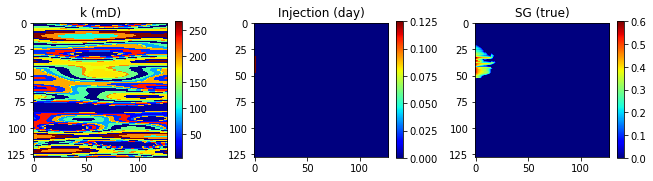

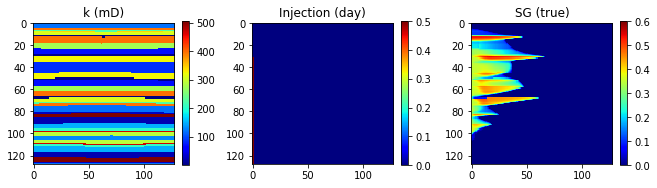

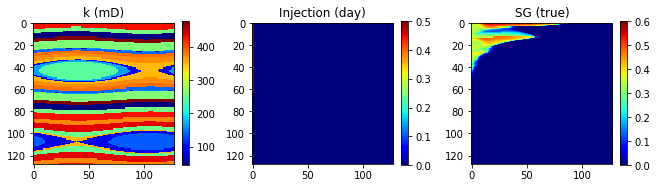

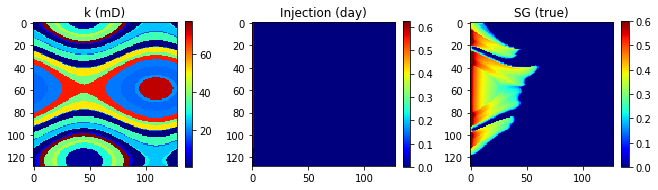

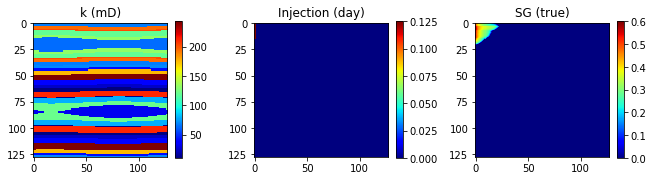

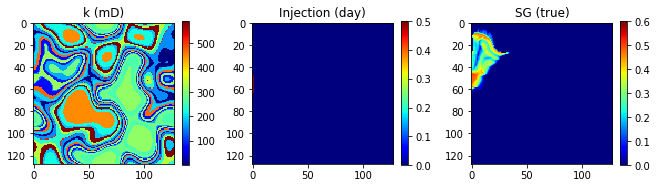

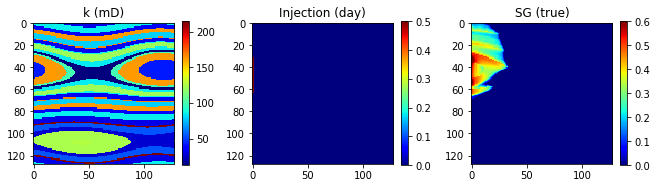

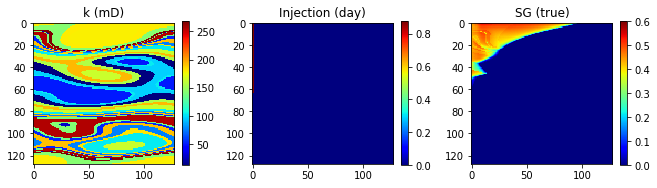

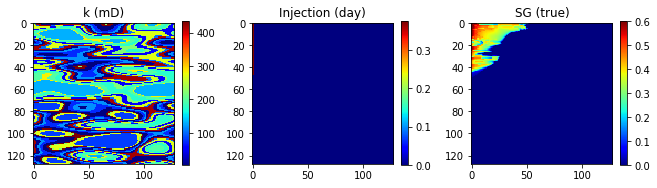

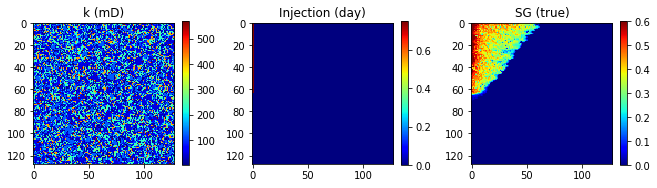

In [8]:
for k in range(0,10):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = train_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()

### Plot test dataset

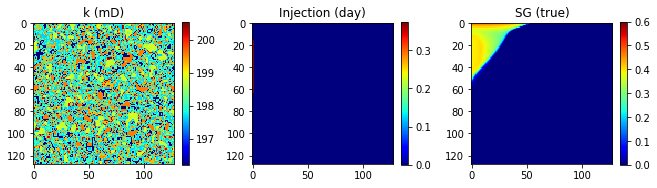

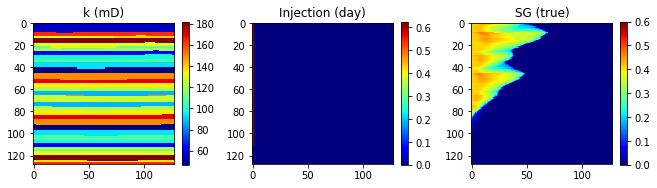

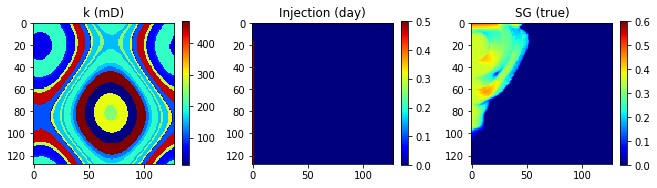

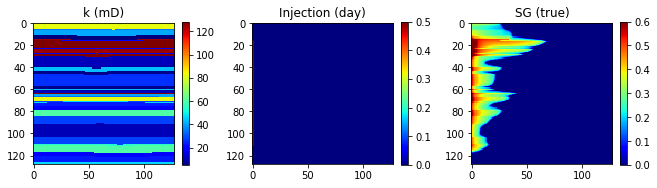

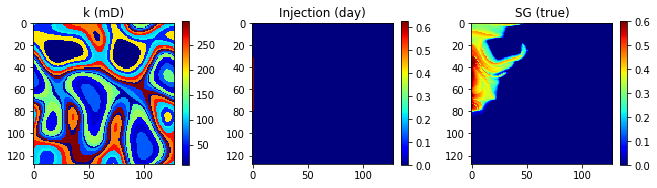

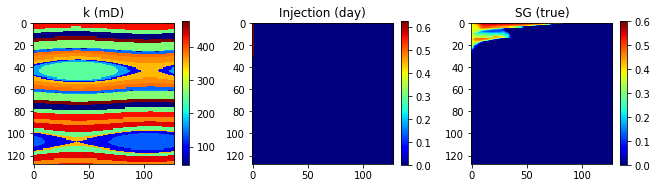

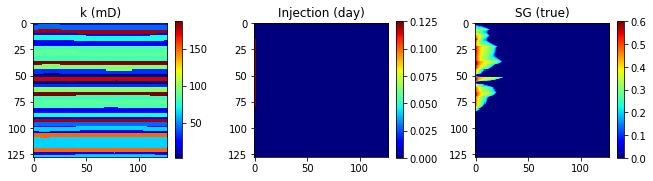

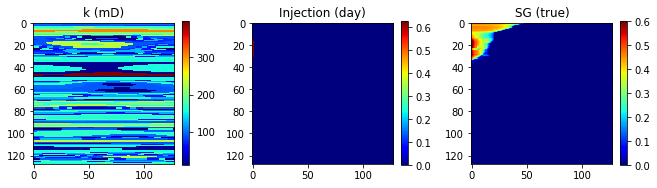

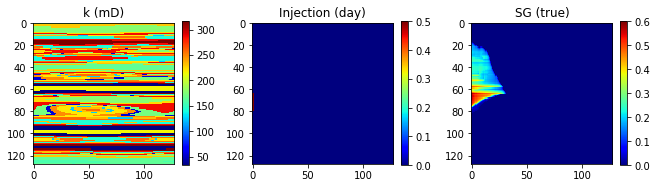

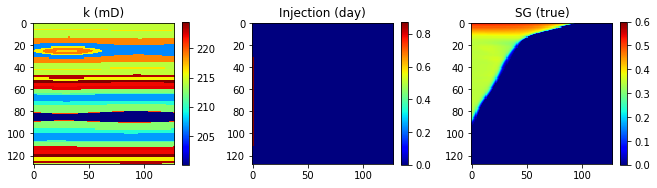

In [9]:
for k in range(0,10):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plot_k = test_x[k, :, :, 1]
    plt.imshow(plot_k)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    plt.title('SG (true)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    

    plt.tight_layout()
    plt.show()

# Training starts here
### Bypass this part if you only want test

In [10]:
vae_model = vae_util.create_vae(input_shape)
vae_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   304         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
# output_dir = '/home/gegewen/well_control/'

In [11]:
epoch = 150
train_nr = train_x.shape[0]
test_nr = 50
batch_size = 16
num_batch = int(train_nr/batch_size) 


In [12]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def BCE_loss(x, t_decoded):
    '''Binary cross entropy loss'''
    return K.losses.binary_crossentropy(x, t_decoded)

In [13]:
opt = Adam(lr=1e-4)

train_target = K.placeholder(shape=(batch_size, 128, 128, 1))
test_target = K.placeholder(shape=(test_nr, 128, 128, 1))

rec_loss = vae_loss(vae_model.output[-1], train_target)
vae_model.compile(optimizer=opt, loss='mse')

total_loss = rec_loss

updates = opt.get_updates(total_loss, vae_model.trainable_weights)

iterate = K.function(vae_model.inputs + [train_target], [rec_loss], updates=updates)

eval_rec_loss = vae_loss(vae_model.output[-1], test_target)

evaluate = K.function(vae_model.inputs + [test_target], [eval_rec_loss])

output_dir = 'saved_models/'

In [14]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print('Elapsed time is ' + str(time.time() - startTime_for_tictoc) + ' seconds.')
        t = time.time() - startTime_for_tictoc
    else:
        print('Toc: start time not set')

In [15]:
tic()
epoch_plot_list = []
rec_loss_list = []
eval_loss_list = []
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        x_batch = train_x[ind0:ind0+batch_size, ...]
        y_batch = train_y[ind0:ind0+batch_size, ...]
        rec_loss_val = iterate([x_batch] + [y_batch])
        if ib % 100 == 0:
            print('Epoch %d/%d, Batch %d/%d, Rec Loss %f' % (e+1, epoch, ib+1, num_batch, rec_loss_val[0]))
    eval_rec_loss_val = evaluate([test_x] + [test_y])
    print('Epoch %d/%d, Train Rec loss %f, Eval Rec loss %f' % (e + 1, epoch, rec_loss_val[0], eval_rec_loss_val[0]))
    rec_loss_list += [rec_loss_val[0]]
    eval_loss_list += [eval_rec_loss_val[0]]
    epoch_plot_list += [e]
    toc()
    if (e+1) % 10 == 0:
        vae_model.save_weights(output_dir + 'well_control_128x128_1col_%dtrain_lr8e-5_ep%d.h5' % (train_nr, (e+1)))

vae_model.save_weights(output_dir + 'well_control_128x128_1col_%dtrain_lr8e-5_ep%d.h5' % (train_nr, epoch))

Epoch 1/150, Batch 1/12, Rec Loss 231.237122
Epoch 1/150, Train Rec loss 147.150146, Eval Rec loss 124.002357
Elapsed time is 8.207913398742676 seconds.
Epoch 2/150, Batch 1/12, Rec Loss 135.088516
Epoch 2/150, Train Rec loss 135.385162, Eval Rec loss 125.852371
Elapsed time is 8.873528242111206 seconds.
Epoch 3/150, Batch 1/12, Rec Loss 129.207642
Epoch 3/150, Train Rec loss 123.554703, Eval Rec loss 137.540771
Elapsed time is 9.549806833267212 seconds.
Epoch 4/150, Batch 1/12, Rec Loss 135.181946
Epoch 4/150, Train Rec loss 124.786987, Eval Rec loss 101.066116
Elapsed time is 10.235381126403809 seconds.
Epoch 5/150, Batch 1/12, Rec Loss 98.182373
Epoch 5/150, Train Rec loss 101.990112, Eval Rec loss 91.619690
Elapsed time is 10.918060541152954 seconds.
Epoch 6/150, Batch 1/12, Rec Loss 84.845848
Epoch 6/150, Train Rec loss 90.882790, Eval Rec loss 89.354408
Elapsed time is 11.60263204574585 seconds.
Epoch 7/150, Batch 1/12, Rec Loss 75.202805
Epoch 7/150, Train Rec loss 88.188675, Ev

Epoch 55/150, Train Rec loss 14.068184, Eval Rec loss 26.221090
Elapsed time is 58.93468451499939 seconds.
Epoch 56/150, Batch 1/12, Rec Loss 18.191071
Epoch 56/150, Train Rec loss 17.499336, Eval Rec loss 26.721661
Elapsed time is 59.61920142173767 seconds.
Epoch 57/150, Batch 1/12, Rec Loss 15.703278
Epoch 57/150, Train Rec loss 17.759613, Eval Rec loss 30.883062
Elapsed time is 60.29161071777344 seconds.
Epoch 58/150, Batch 1/12, Rec Loss 18.963768
Epoch 58/150, Train Rec loss 13.613461, Eval Rec loss 25.731358
Elapsed time is 61.00018620491028 seconds.
Epoch 59/150, Batch 1/12, Rec Loss 13.434763
Epoch 59/150, Train Rec loss 11.884798, Eval Rec loss 25.639816
Elapsed time is 61.67893385887146 seconds.
Epoch 60/150, Batch 1/12, Rec Loss 14.057562
Epoch 60/150, Train Rec loss 15.378518, Eval Rec loss 26.244251
Elapsed time is 62.369473457336426 seconds.
Epoch 61/150, Batch 1/12, Rec Loss 15.627218
Epoch 61/150, Train Rec loss 12.200367, Eval Rec loss 26.157867
Elapsed time is 65.6764

Epoch 109/150, Train Rec loss 7.305070, Eval Rec loss 24.205036
Elapsed time is 105.31829833984375 seconds.
Epoch 110/150, Batch 1/12, Rec Loss 7.666716
Epoch 110/150, Train Rec loss 7.783428, Eval Rec loss 23.377216
Elapsed time is 106.01583194732666 seconds.
Epoch 111/150, Batch 1/12, Rec Loss 7.689027
Epoch 111/150, Train Rec loss 10.552104, Eval Rec loss 25.201704
Elapsed time is 107.35557794570923 seconds.
Epoch 112/150, Batch 1/12, Rec Loss 8.144970
Epoch 112/150, Train Rec loss 11.206484, Eval Rec loss 27.672888
Elapsed time is 108.03578305244446 seconds.
Epoch 113/150, Batch 1/12, Rec Loss 10.311583
Epoch 113/150, Train Rec loss 8.063132, Eval Rec loss 27.975643
Elapsed time is 108.71289944648743 seconds.
Epoch 114/150, Batch 1/12, Rec Loss 10.136091
Epoch 114/150, Train Rec loss 7.726395, Eval Rec loss 26.070736
Elapsed time is 109.39144778251648 seconds.
Epoch 115/150, Batch 1/12, Rec Loss 7.994633
Epoch 115/150, Train Rec loss 8.708693, Eval Rec loss 25.877893
Elapsed time i

# Test starts here

### Do not need to run training section

In [12]:
epoch = 130
train_nr = train_x.shape[0]
test_nr = 10
output_dir = 'saved_models/'

vae_model = vae_util.create_vae(input_shape)
# vae_model.summary()

print(output_dir + 'well_control_128x128_1col_%dtrain_lr8e-5_ep%d.h5' % (train_nr, epoch))
vae_model.load_weights(output_dir + 'well_control_128x128_1col_%dtrain_lr8e-5_ep%d.h5' % (train_nr, epoch))

saved_models/well_control_128x128_1col_200train_lr8e-5_ep130.h5


In [13]:
vae_weights = vae_model.get_weights()
vae_weights[0].shape

(3, 3, 2, 16)

In [14]:
sat_pred_eval = vae_model.predict(test_x)
sat_pred_eval[0].shape

(80, 64, 64, 16)

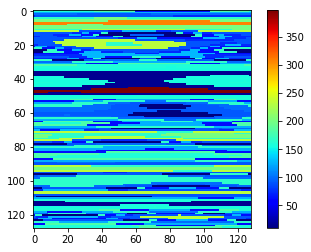

In [15]:
num_test = 7
k_fig = plt.figure()
plt.imshow(test_x[num_test,:,:,0]*1000)
plt.colorbar(fraction=0.046)

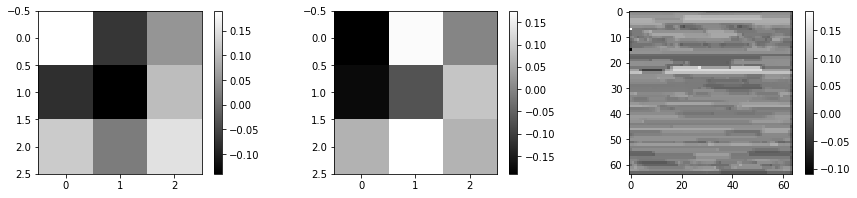

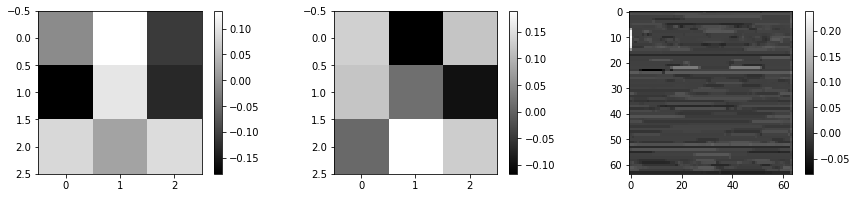

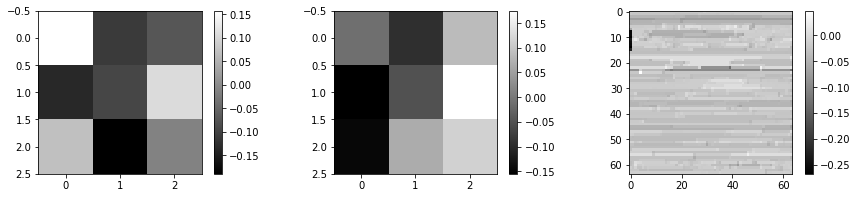

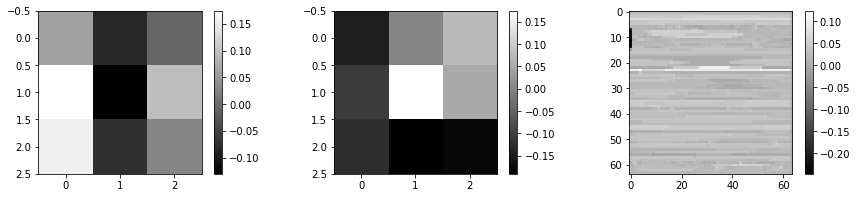

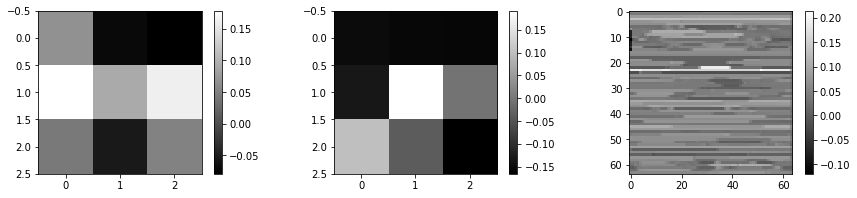

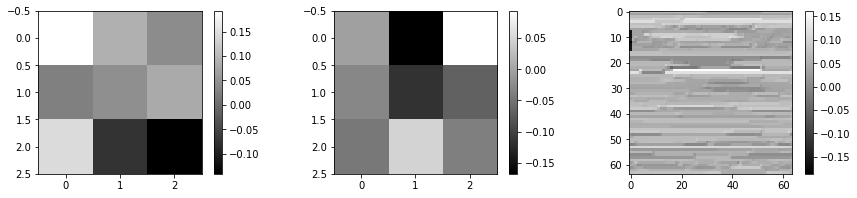

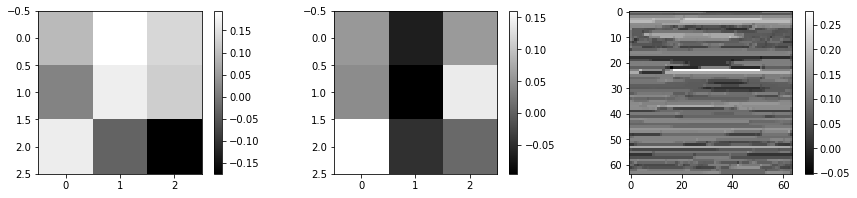

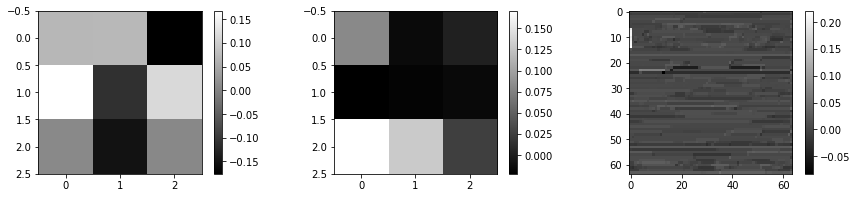

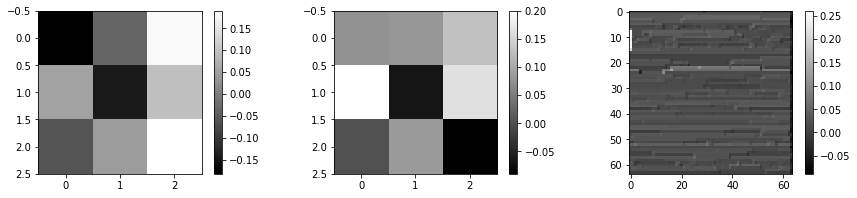

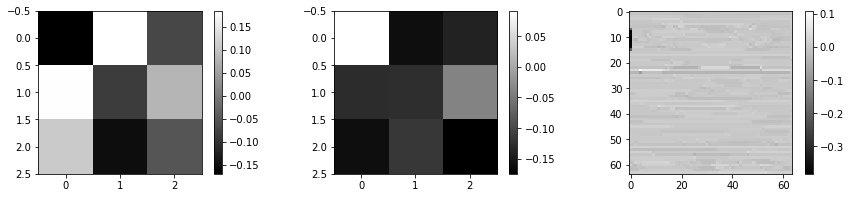

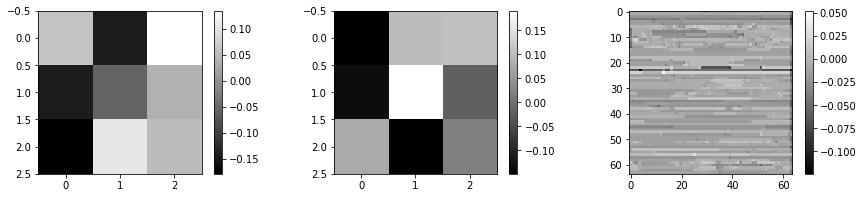

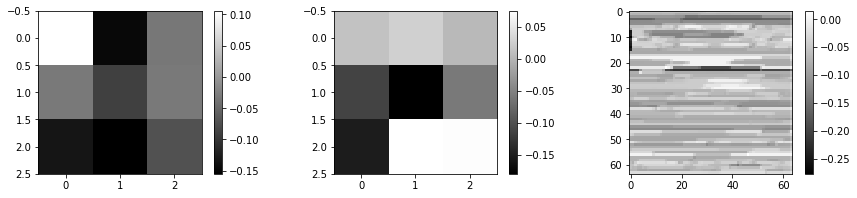

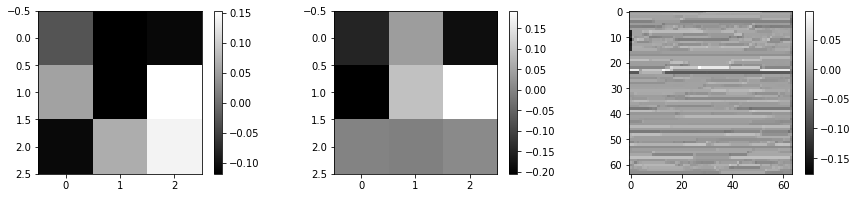

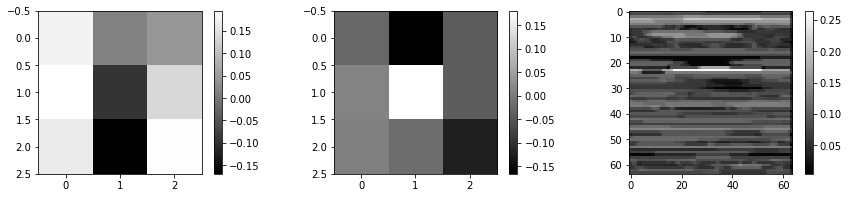

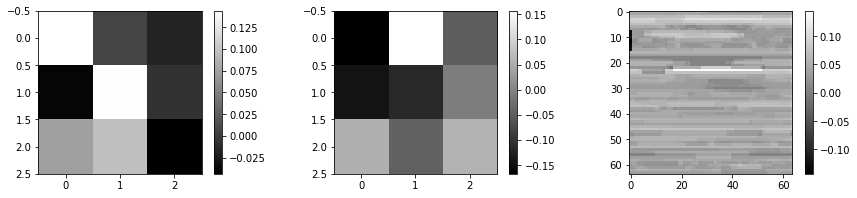

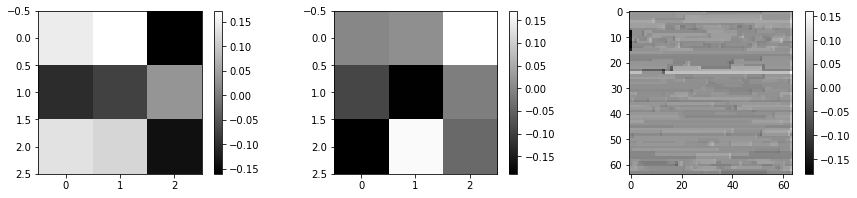

In [16]:
num_test = 7

for i in range(16):
    fig = plt.figure(figsize=(15,3))
    plt.set_cmap('gray')
    
    plt.subplot(1,3,1)
    plt.imshow(vae_weights[0][:,:,0,i])
    plt.colorbar(fraction=0.046)
#     plt.clim([-0.1, 0.1])

    plt.subplot(1,3,2)
    plt.imshow(vae_weights[0][:,:,1,i])
    plt.colorbar(fraction=0.046)
#     plt.clim([-0.1, 0.1])

    plt.subplot(1,3,3)
#     plt.set_cmap('jet')
    plt.imshow(sat_pred_eval[0][num_test,:,:,i])
    plt.colorbar(fraction=0.046)
#     fig.savefig('layer1'+'channel'+str(i)+'.png')


/data3/Astro/global/miniconda3/envs/tf-1.10.0/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

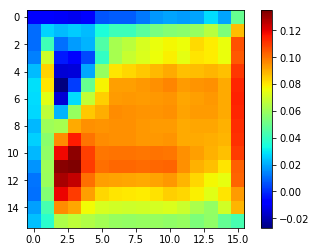

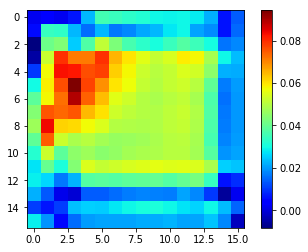

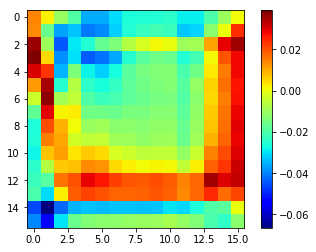

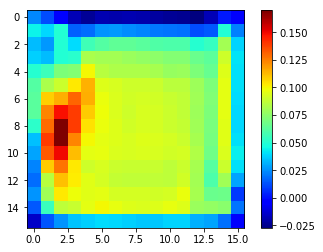

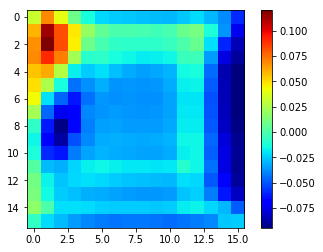

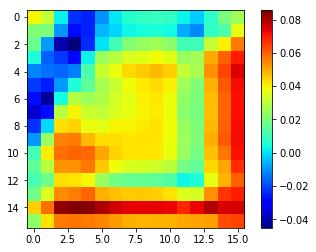

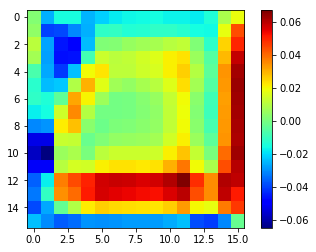

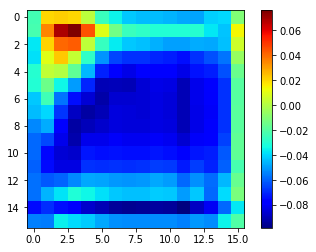

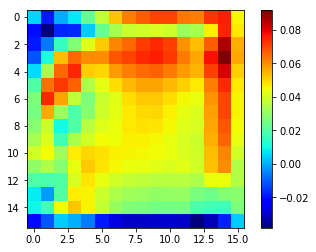

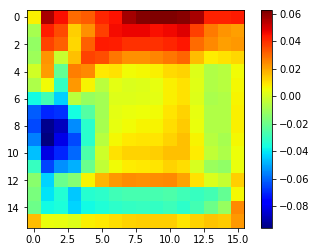

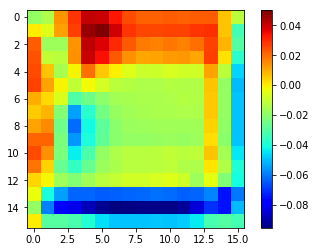

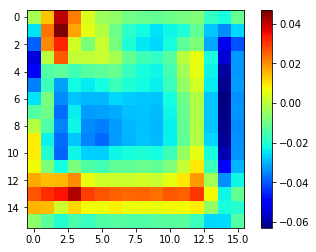

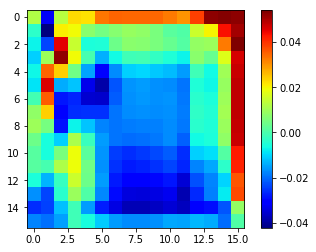

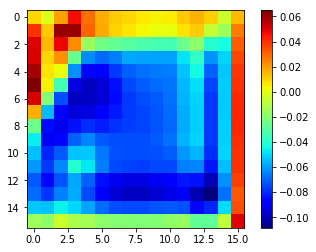

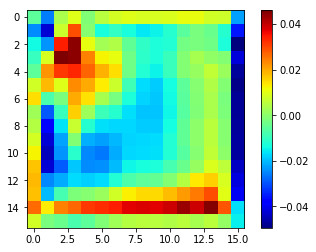

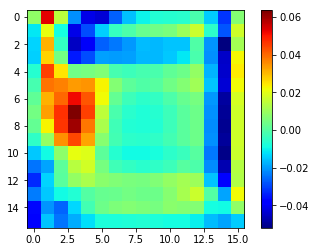

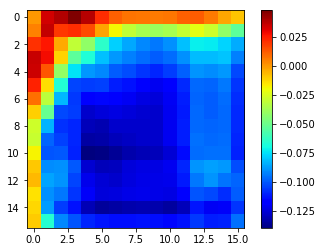

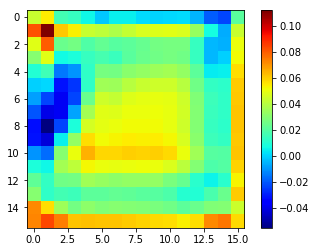

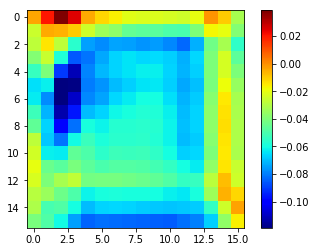

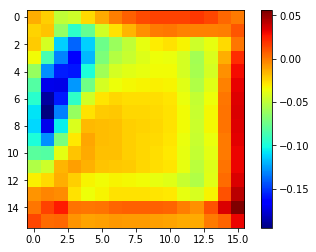

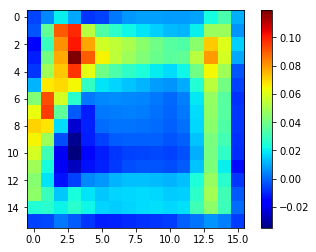

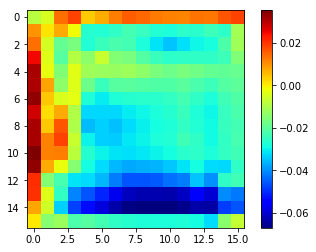

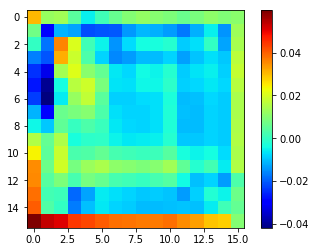

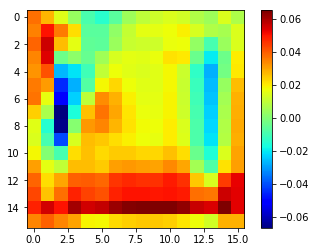

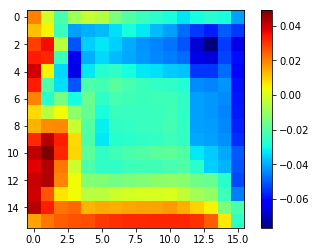

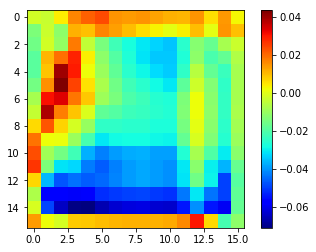

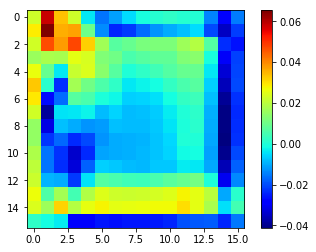

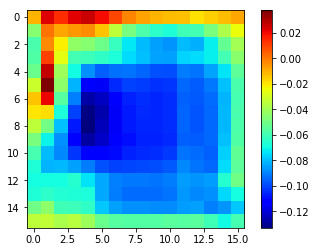

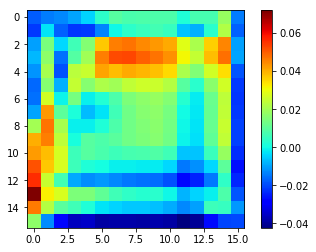

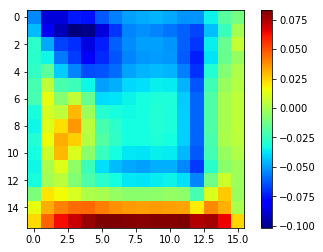

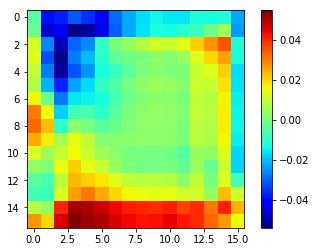

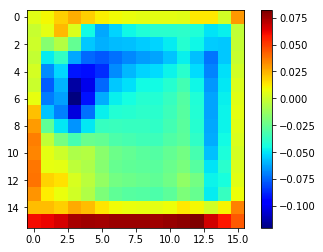

In [17]:
plt.set_cmap('jet')
# k_fig = plt.figure()
# plt.imshow(test_x[0,:,:,0])
# plt.colorbar(fraction=0.046)
# k_fig.savefig('k.png')
layer = 11
for i in range(32):
    fig = plt.figure()
    plt.imshow(sat_pred_eval[layer-1][0,:,:,i])
    plt.colorbar(fraction=0.046)
    fig.savefig('figs/layer'+str(layer)+'channel'+str(i)+'.png')


In [18]:
sat_pred_eval = vae_model.predict(test_x)
sat_pred_eval[-1].shape

(80, 128, 128, 1)

In [19]:
sat_pred_train = vae_model.predict(train_x[:10,...])
sat_pred_train[-1].shape

(10, 128, 128, 1)

In [20]:
epoch_plot = np.asarray(epoch_plot_list)+1
rec_loss = np.asarray(rec_loss_list)/16384/16
eval_loss = np.asarray(eval_loss_list)/16384/16
rec_loss = np.sqrt(rec_loss)
eval_loss = np.sqrt(eval_loss)
# print(epoch_plot)
# print(rec_loss)
# print(eval_loss)

NameError: name 'epoch_plot_list' is not defined

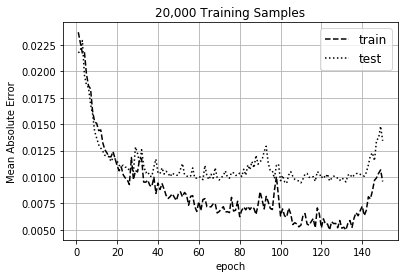

In [28]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(epoch_plot, rec_loss,  'k--', label='train')
ax.plot(epoch_plot, eval_loss,  'k:', label='test')


legend = ax.legend(loc='upper right', fontsize='large')

ax.set(xlabel='epoch', ylabel='Mean Absolute Error',
        title='20,000 Training Samples')
ax.grid()

fig.savefig("test.png")
plt.show()

In [21]:
train_inj_plot = train_x * 200
train_inj_plot[:, :, 1 ,1] = train_inj_plot[:, :, 0, 1]
train_inj_plot[:, :, 2 ,1] = train_inj_plot[:, :, 0, 1]
test_inj_plot = test_x * 200
test_inj_plot[:, :, 1 ,1] = test_inj_plot[:, :, 0, 1]
test_inj_plot[:, :, 2 ,1] = test_inj_plot[:, :, 0, 1]

## Train simulation results

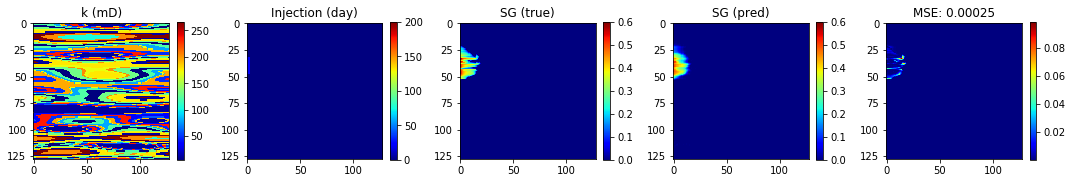

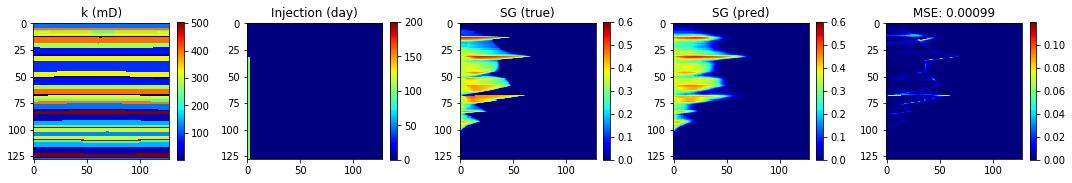

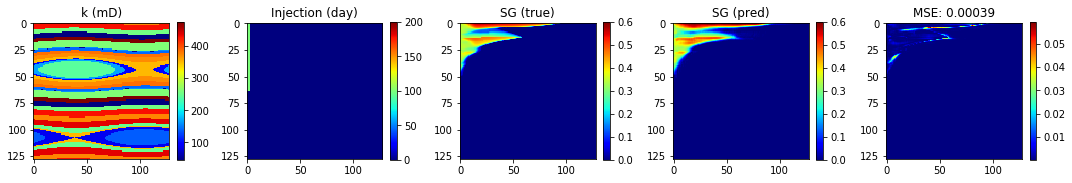

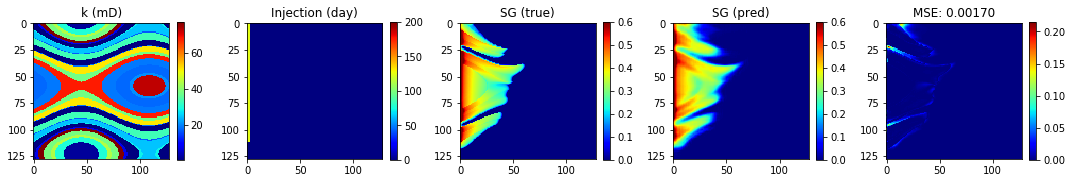

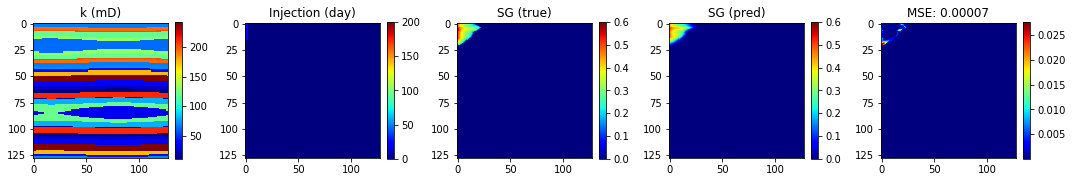

In [22]:
for k in range(0,5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('k (mD)')
    plt.imshow(train_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plt.imshow(train_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('SG (true)')
    plt.imshow(train_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,4)
    plt.imshow(sat_pred_train[-1][k, :, :, 0].reshape(128, 128))
    plt.title('SG (pred)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,5)
    rel_err = np.square((sat_pred_train[-1][k, :, :, 0] - train_y[k, :, :, 0]))
    plt.imshow(rel_err) 
    mean_err = np.mean(rel_err)
    plt.title('MSE: %.5f' % mean_err)
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
    plt.show()

    

## Test simulation results

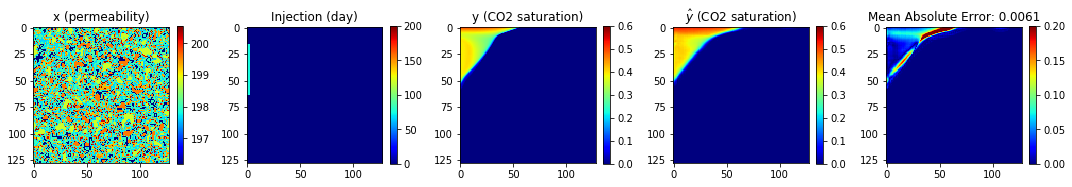

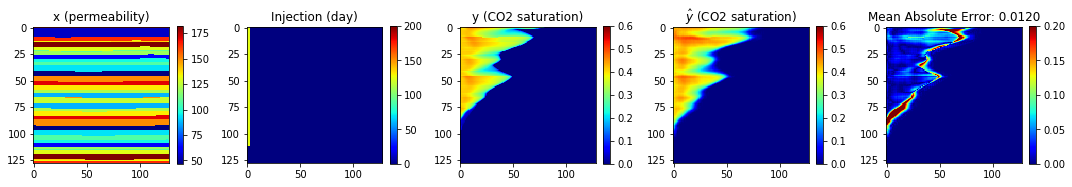

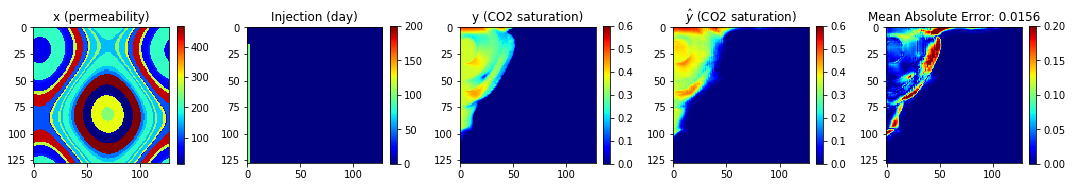

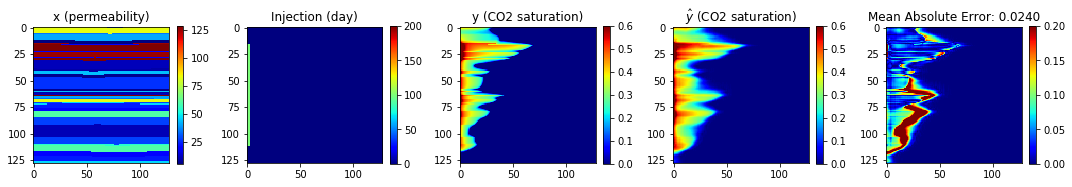

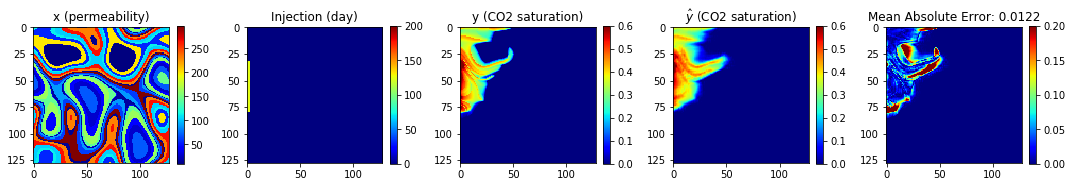

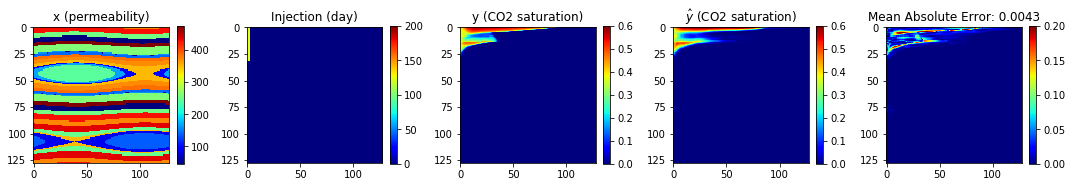

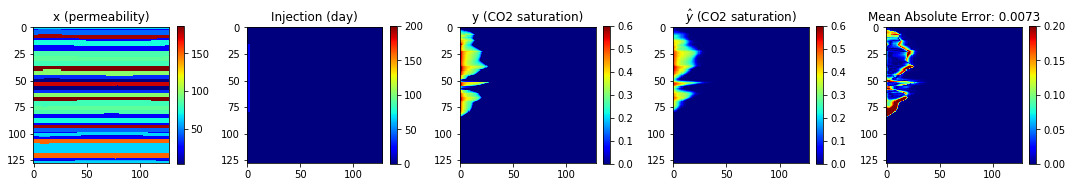

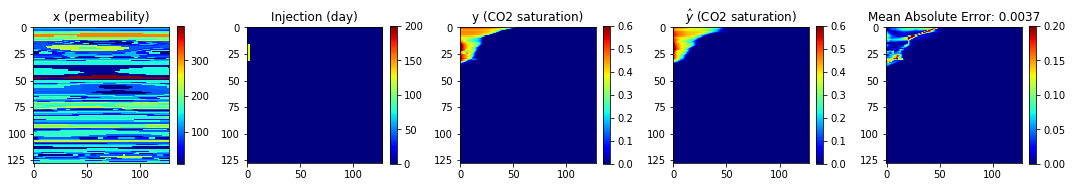

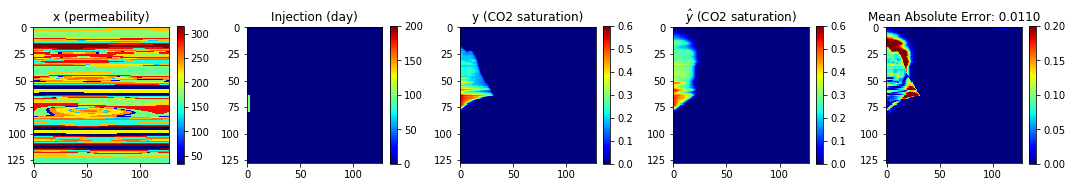

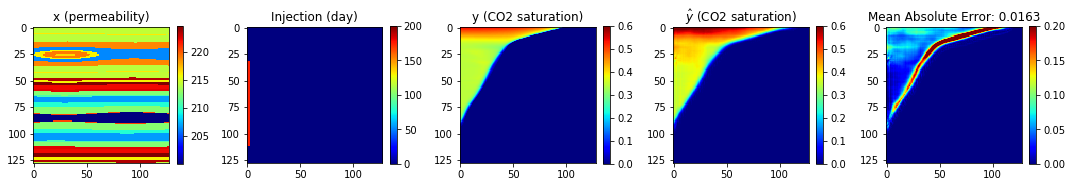

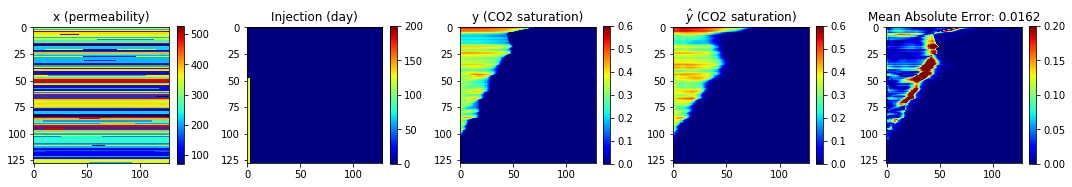

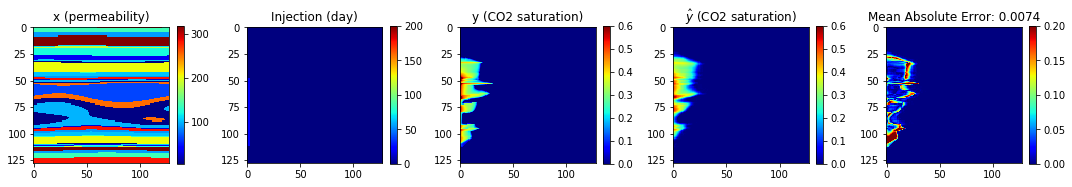

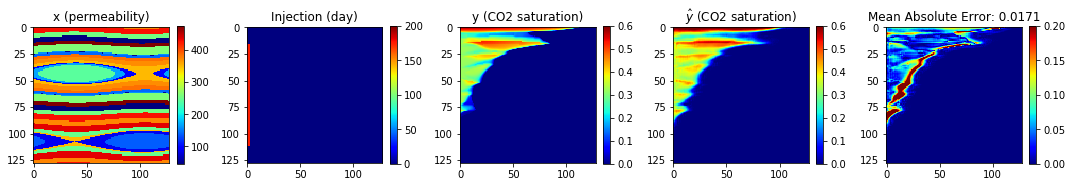

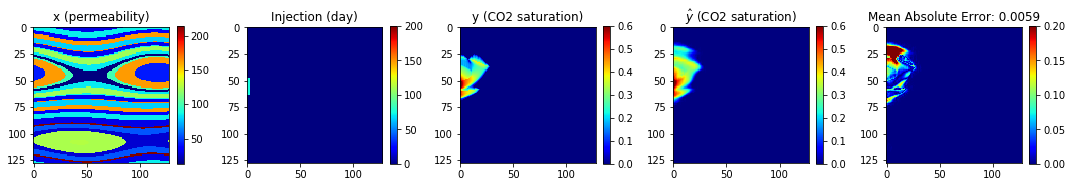

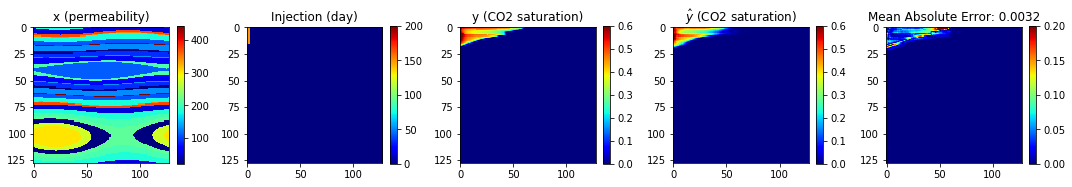

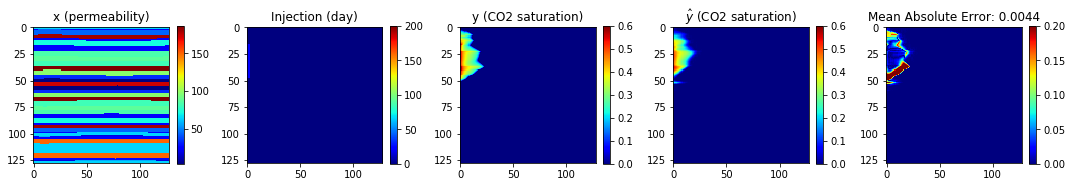

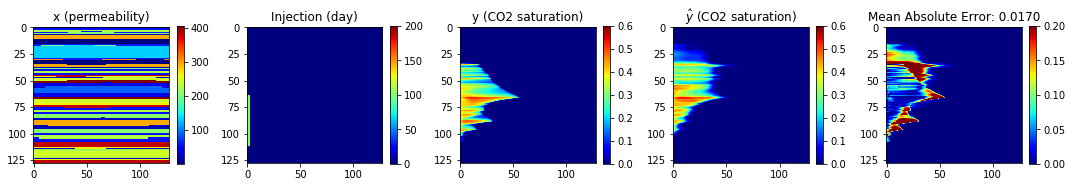

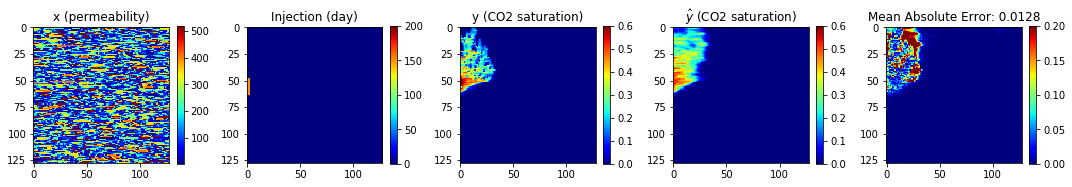

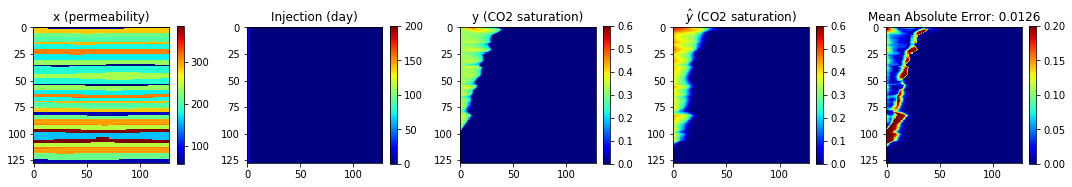

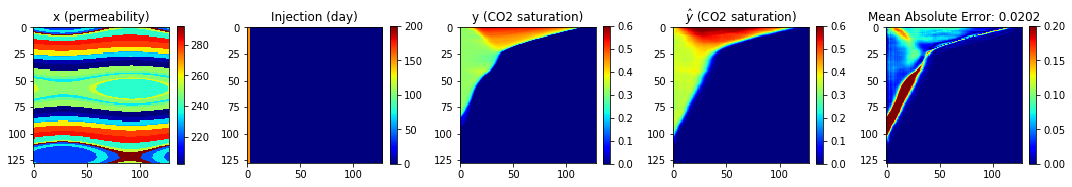

In [23]:
for k in range(0,20):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('x (permeability)')
    plt.imshow(test_x[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plt.imshow(test_inj_plot[k, :, :, 1])
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    inj = test_x[k, 1, 1, 0]*50
    plt.title('y (CO2 saturation)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,4)
    plt.imshow(sat_pred_eval[-1][k, :, :, 0].reshape(128, 128))
    plt.title('$\hat{y}$ (CO2 saturation)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,5)
    abs_err = np.abs((sat_pred_eval[-1][k, :, :, 0] - test_y[k, :, :, 0]))
#     rel_err = abs_err/(test_y[k, :, :, 0]+0.01)
    plt.imshow(abs_err) 
#     mean_err = np.mean(rel_err)
    mean_err = np.mean(abs_err)
    plt.title('Mean Absolute Error: %.4f' % mean_err)
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
    plt.tight_layout()
    plt.show()

    

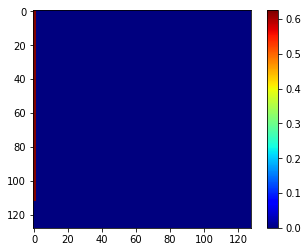

In [24]:
test_inj_2 = test_x
test_inj_2[:, :, 1 ,1] = test_inj_2[:, :, 0, 1]
test_inj_2[:, :64, 0:1 , 1] = test_inj_2[:, :64, 0:1, 1] 
plt.imshow(test_inj_2[1, :, :, 1])
# plt.clim(0, 200)
plt.colorbar(fraction=0.046)

In [25]:
sat_pred_train = vae_model.predict(test_inj_2)
sat_pred_train[-1].shape

(80, 128, 128, 1)

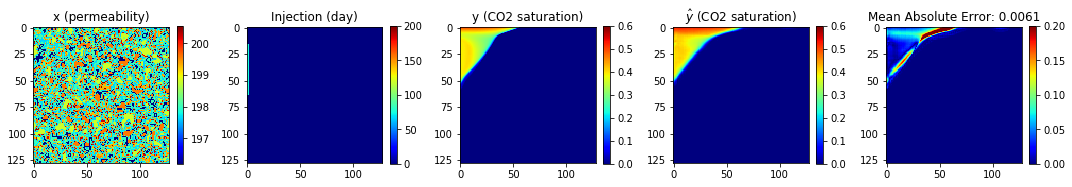

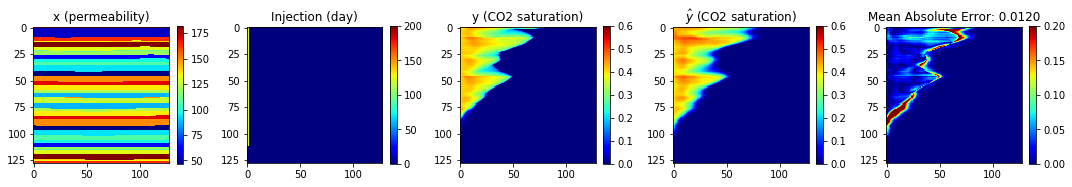

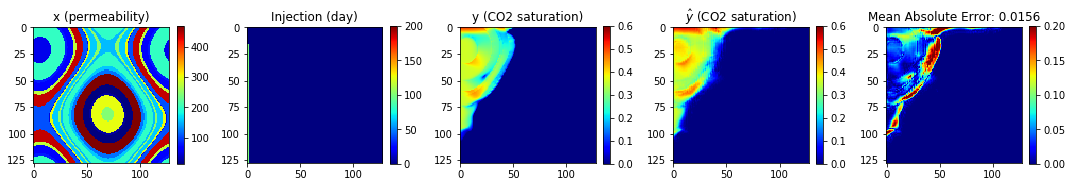

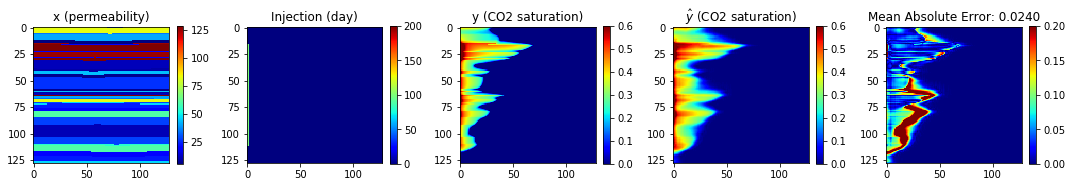

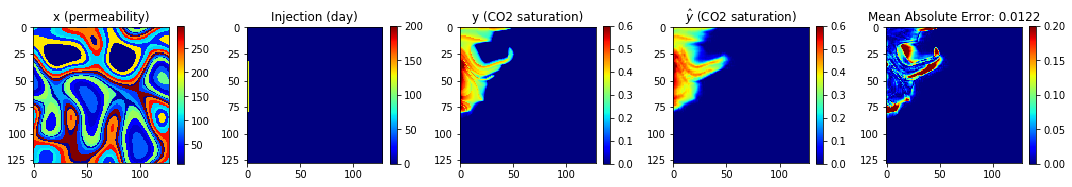

In [26]:
for k in range(0,5):
    plt.figure(k,figsize=(15,3))
    
    plt.subplot(1,5,1)
    plt.title('x (permeability)')
    plt.imshow(test_inj_2[k, :, :, 0] * 1000)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,2)
    plt.title('Injection (day)')
    plt.imshow(test_inj_2[k, :, :, 1]*200)
    plt.clim(0, 200)
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,3)
    inj = test_inj_2[k, 1, 1, 0]*50
    plt.title('y (CO2 saturation)')
    plt.imshow(test_y[k, :, :, 0].reshape(128, 128))
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,4)
    plt.imshow(sat_pred_train[-1][k, :, :, 0].reshape(128, 128))
    plt.title('$\hat{y}$ (CO2 saturation)')
    plt.clim([0, 0.6])
    plt.colorbar(fraction=0.046)
    
    plt.subplot(1,5,5)
    abs_err = np.abs((sat_pred_train[-1][k, :, :, 0] - test_y[k, :, :, 0]))
#     rel_err = abs_err/(test_y[k, :, :, 0]+0.01)
    plt.imshow(abs_err) 
#     mean_err = np.mean(rel_err)
    mean_err = np.mean(abs_err)
    plt.title('Mean Absolute Error: %.4f' % mean_err)
    plt.colorbar(fraction=0.046)
    plt.clim([0, 0.2])
    plt.tight_layout()
    plt.show()